1) Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.



R: Se eliminaron variables con alta cantidad de datos faltantes (P6_9am, P6_3pm, Leakage), en el caso de leakage, también se considero eliminarla dada su alta cantidad de outliers. Se reemplazaron NaN por 0 en Evaporation y Electricity, generando columnas binarias que identificar los NaN reemplazados. Se generó una variable binaria a partir de Failure_today, además, se descartaron variables altamente correlacionadas, identificadas a partir de la matriz de correlación. Posteriormente, las variables categóricas como P1_Dir, P2_9am, P2_3pm, y Location se transformaron a dummies. 

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
import matplotlib.patches as patches
import warnings
import math
warnings.filterwarnings("ignore")
%matplotlib inline

In [249]:
df = pd.read_csv('machine_failure_data.csv', delimiter=",", decimal=',')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Fecha'] = df['Date']
df['Date'] = df['Date'].dt.year.astype(int)
df = df[df['Fecha'].dt.year >= 2009]
df.columns = [col.replace('Parameter', 'P') if 'Parameter' in col else col for col in df.columns]

In [250]:
#Eliminamos las variables p6, que tienen muchos NaN, al igual que las filtraciones que tienen muchos outliers
df = df.drop(['P6_9am', 'P6_3pm', 'Leakage'], axis=1)

In [251]:
# Dejamos solo direcciones cardinal principales (N, S, E, W)
direccion = ['P1_Dir', 'P2_9am', 'P2_3pm']
for i in direccion:
    df[i] = df[i].astype(str).str[0]

df1 = df.copy()

In [252]:
# Crear columnas indicadoras donde había NaN (antes de reemplazarlos)
df['Evaporation_NaN'] = df['Evaporation'].isna().astype(int)
df['Electricity_NaN'] = df['Electricity'].isna().astype(int)

# Reemplazar NaN por 0 en las columnas originales
df['Evaporation'] = df['Evaporation'].fillna(0)
df['Electricity'] = df['Electricity'].fillna(0)

LIMPIEZA Y CONVERSIÓN DE DATOS

In [253]:
# ELIMINAMOS LOS NAN DE LA BASE DE DATOS
df.dropna(inplace=True)

In [254]:
# CONVERTIMOS LA COLUMNA A UNA BINARIA DE 1's y 0's
df['Failure_today'] = df['Failure_today'].map({'No': 0, 'Yes': 1})

cols_a_convertir = [
    'Min_Temp', 'Max_Temp', 'Evaporation', 'Electricity',
    'P7_9am', 'P7_3pm', 'P5_9am', 'P5_3pm', 'Failure_today'
]

for col in cols_a_convertir:
    df[col] = pd.to_numeric(df[col], errors='coerce')

CONVERTIMOS LAS VARIABLES CATEGÓRICAS A NÚMEROS PARA GRÁFICAR (POSTERIMENTE SE PASARÁN A DUMMI)

In [255]:
for col in ['P1_Dir', 'P2_9am', 'P2_3pm']:
    df[col], _ = pd.factorize(df[col])

REVISIÓN DE DISTRIBUCIÓN Y OUTLIERS (HISTOGRAMAS Y BOXPLOT)

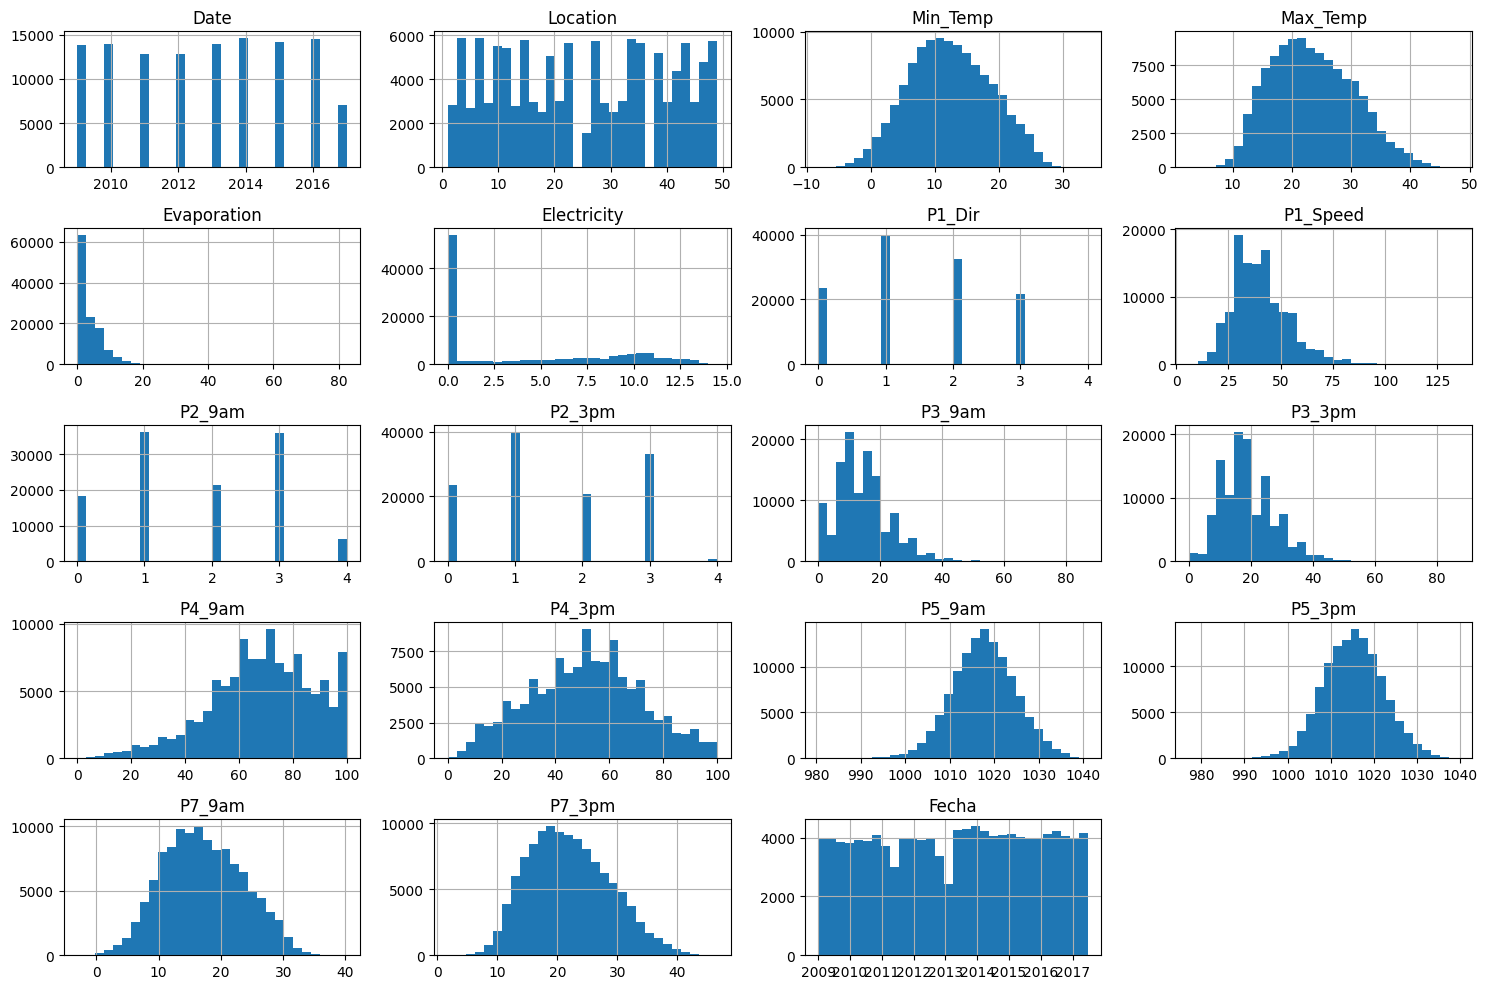

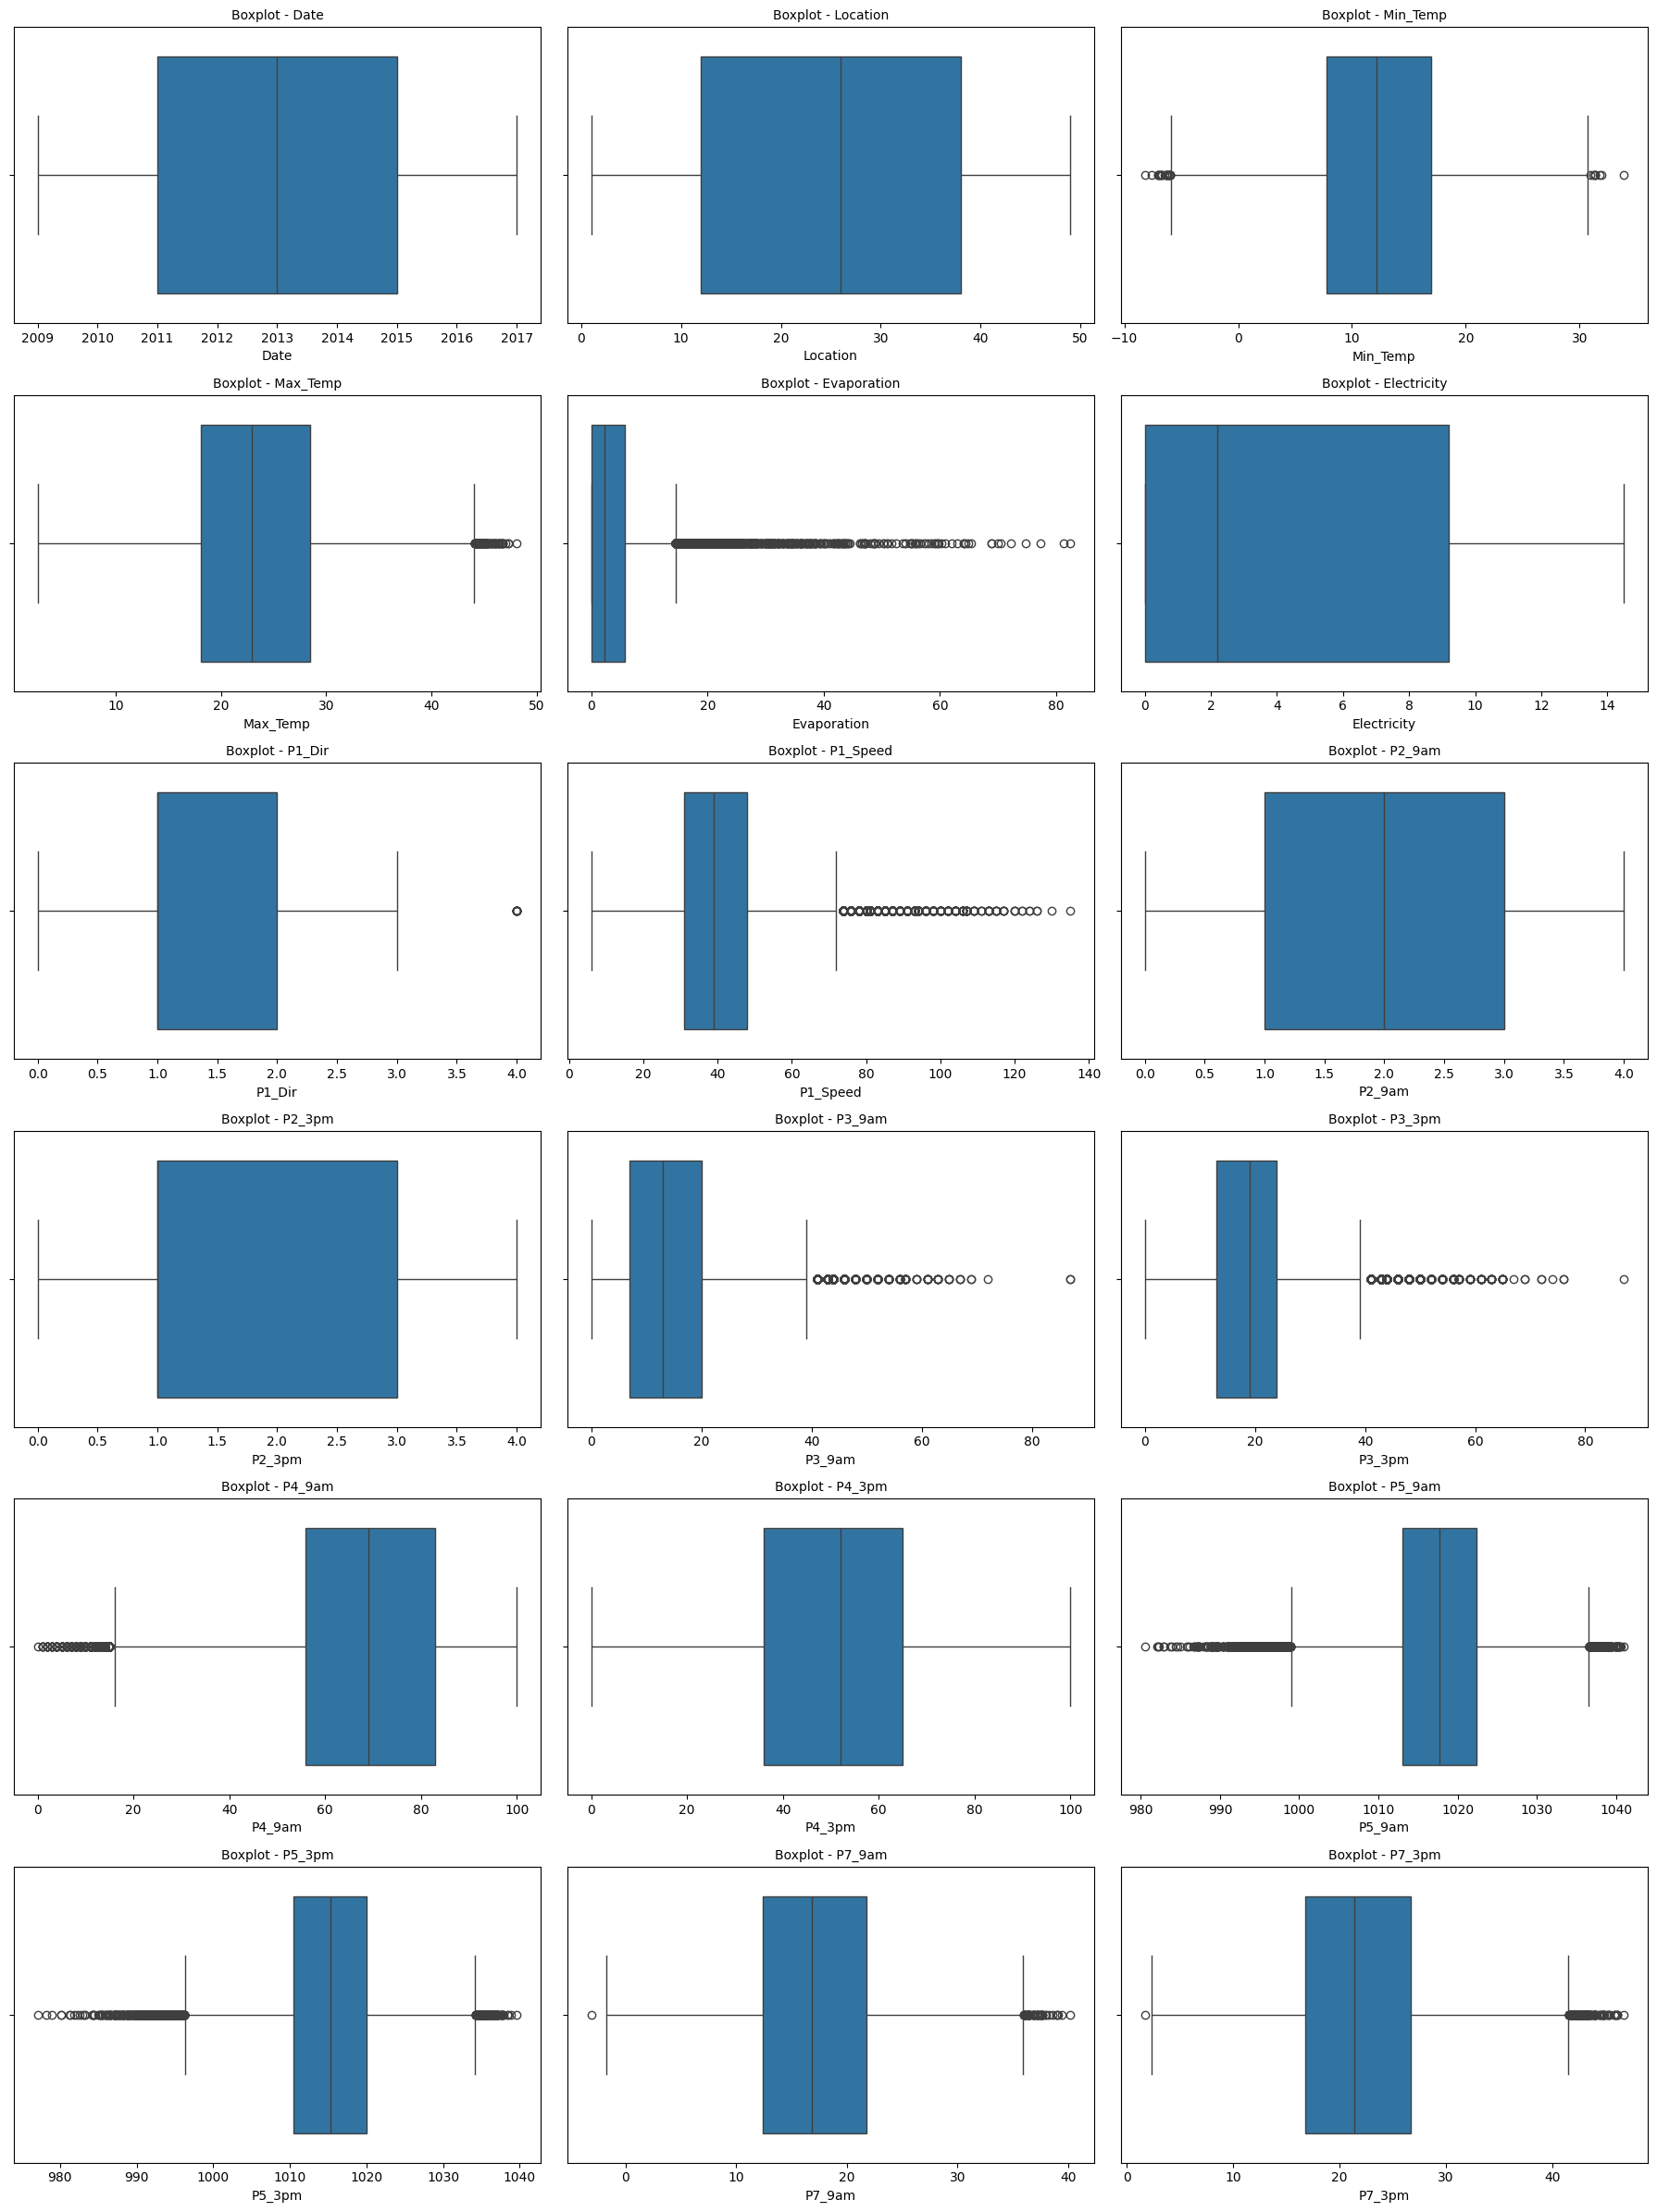

In [256]:
# Excluir columnas binarias (con solo 2 valores únicos)
df_non_binary = df.loc[:, df.nunique() > 2]

df_non_binary.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

numeric_cols = df_non_binary.select_dtypes(include=[np.number]).columns

cols_per_row = 3
total = len(numeric_cols)
rows = math.ceil(total / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_non_binary[col], ax=axes[i])
    axes[i].set_title(f'Boxplot - {col}', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

MATRIZ DE CORRELACIONES INCLUYENDO TODAS LAS VARIABBLES (SIN DUMMIES, CON CATEGÓRICAS)

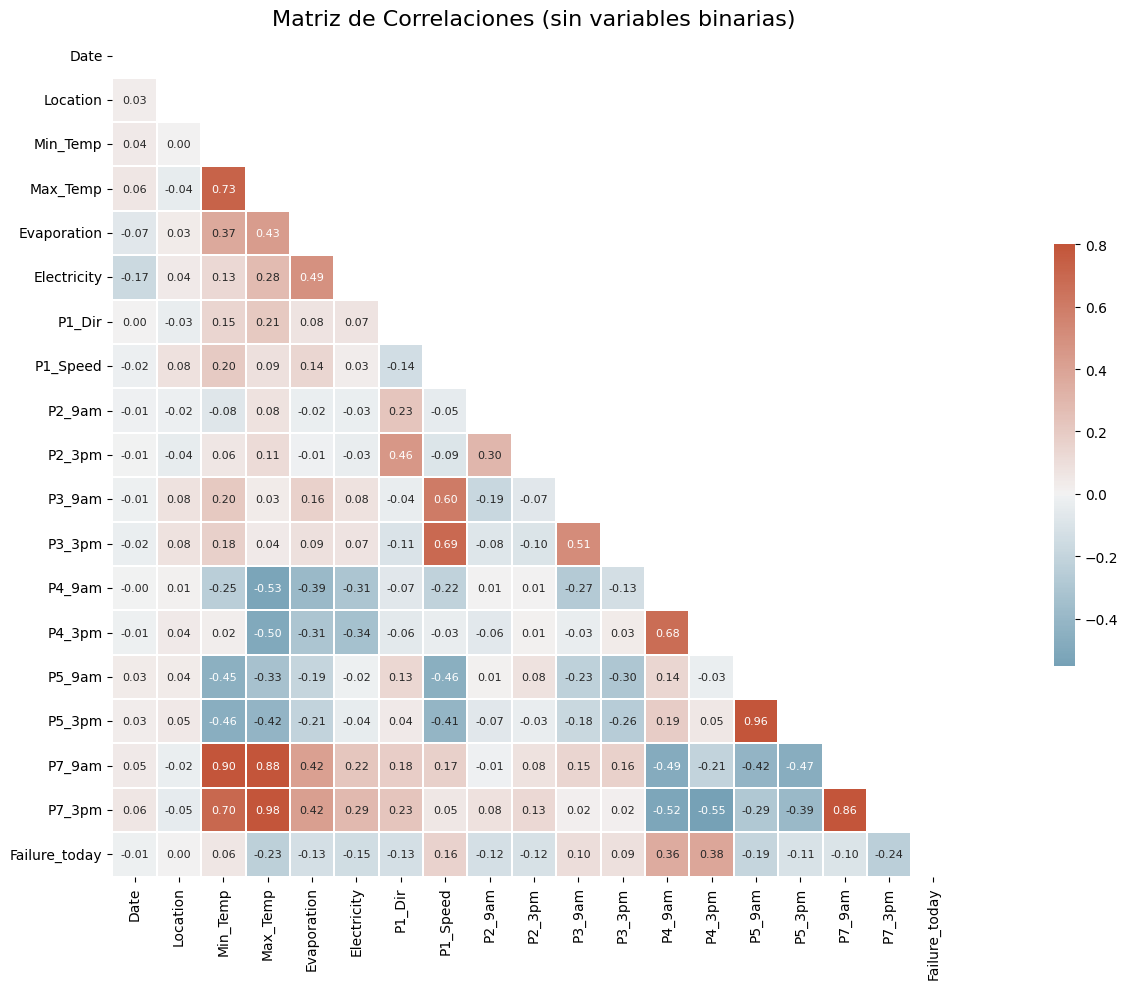

In [257]:
cols_non_binary = [col for col in df.columns if (df[col].nunique() > 2) or (col == 'Failure_today')]
df_corr = df[[col for col in cols_non_binary if col != 'Fecha']]

corr = df_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8},
            xticklabels=True, yticklabels=True)

labels = corr.columns
failure_index = list(labels).index('Failure_today')


plt.title("Matriz de Correlaciones (sin variables binarias)", fontsize=16)
plt.tight_layout()
plt.show()


In [258]:
# Eliminamos las variables que tienen mucha correlación entre ellas, dejando una, en este caso "Min_Temp"
df = df.drop(['Max_Temp', 'P7_9am', 'P7_3pm'], axis=1)

# En este caso ambas variables miden lo mismo en horas distintas y tienen una correlación superior a 0.9, eliminamos una
df = df.drop(['P5_3pm'], axis=1)

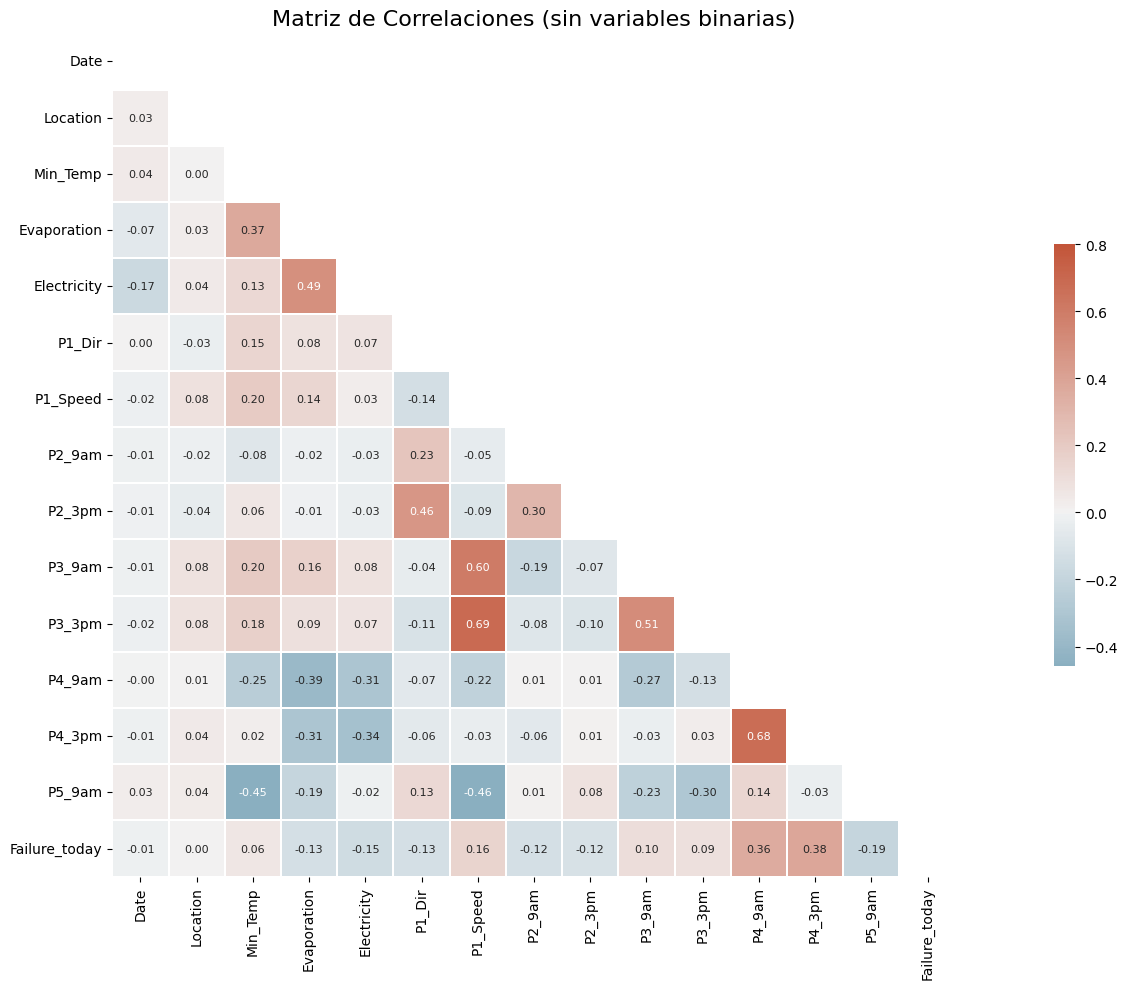

In [259]:
cols_non_binary = [col for col in df.columns if (df[col].nunique() > 2) or (col == 'Failure_today')]
df_corr = df[[col for col in cols_non_binary if col != 'Fecha']]

corr = df_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8},
            xticklabels=True, yticklabels=True)

labels = corr.columns
failure_index = list(labels).index('Failure_today')

plt.title("Matriz de Correlaciones (sin variables binarias)", fontsize=16)
plt.tight_layout()
plt.show()


CONVERTIMOS LAS VARIABLES CATEGÓRICAS EN COLUMNAS DUMMI PARA PODER HACER LA REGRESIÓN

In [260]:
df2 = df.copy()
df = df.drop(['Fecha'], axis=1)

df = pd.get_dummies(df, columns=['Location', 'P1_Dir', 'P2_9am', 'P2_3pm', 'Date'], drop_first=True)

# Reemplazar True por 1 y False por 0 en todo el DataFrame
df = df.replace({True: 1, False: 0})

2) Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.


R: El modelo muestra que variables como Min_Temp, P1_Speed, P3_9am, P4_9am y P4_3pm tienen una asociación positiva con la probabilidad de fallo, mientras que Evaporation, Electricity, P3_3pm y P5_9am presentan efectos negativos. Las variables indicadoras de datos faltantes (Evaporation_NaN, Electricity_NaN) también muestran asociaciones negativas significativas, lo cual sugiere que la ausencia de estas mediciones se relaciona con menor probabilidad de fallo.

En el caso de las ubicaciones, la mayoría de los coeficientes son negativos, lo que indica que varias zonas presentan menor probabilidad de falla respecto del baseline.

REGRESIÓN MCO PARA LA VARIABLE "Failure_Today"

In [261]:
y=df['Failure_today']
X=df.drop(['Failure_today'], axis=1)
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     614.6
Date:               jue, 24 abr. 2025   Prob (F-statistic):               0.00
Time:                        22:42:09   Log-Likelihood:                -44586.
No. Observations:              117793   AIC:                         8.932e+04
Df Residuals:                  117718   BIC:                         9.005e+04
Df Model:                          74                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.4277      0.219     

## 3) Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

R: El modelo probit refuerza los resultados del MCO y entrega una mejor representación de la variable dependiente. Las variables Min_Temp, P1_Speed, P3_9am, P4_9am y P4_3pm aumentan significativamente la probabilidad de que ocurra un fallo, mientras que Evaporation, P3_3pm, P5_9am y ciertas direcciones del viento se asocian negativamente. Se observaron diferencias de magnitud respecto a OLS, con efectos marginales más grandes en torno al promedio. Por ejemplo, un cambio unitario en P4_9am implica un aumento marginal importante en la probabilidad de fallo.

In [262]:
X1 = X.copy() 
X1 = sm.add_constant(X1)  
model = sm.Probit(y, X1)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.367778
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               117793
Model:                         Probit   Df Residuals:                   117718
Method:                           MLE   Df Model:                           74
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3037
Time:                        22:42:12   Log-Likelihood:                -43322.
converged:                       True   LL-Null:                       -62216.
Covariance Type:                  HC0   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.4562      0.941     31.306      0.000      27.612      31.300
Min_Temp      

## 4) Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

R: Los coeficientes marginales del modelo logit son muy similares a los obtenidos en el modelo probit, tanto en signo como en magnitud, lo cual es esperable. Sin embargo, logit permite interpretar los resultados también en términos de razón de odds (odds ratio), lo que entrega una visión más completa del efecto relativo de cada variable sobre la probabilidad de fallo. El modelo mantiene la significancia de las variables clave y muestra un leve aumento en el pseudo R² respecto al modelo probit.

In [263]:
model = sm.Logit(y, X1)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.366616
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               117793
Model:                          Logit   Df Residuals:                   117718
Method:                           MLE   Df Model:                           74
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3059
Time:                        22:42:14   Log-Likelihood:                -43185.
converged:                       True   LL-Null:                       -62216.
Covariance Type:                  HC0   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              51.4770      1.662     30.965      0.000      48.219      54.735
Min_Temp      

## 5) Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?



R: En base a los resultados, el modelo MCO entrega una aproximación inicial, pero no modela adecuadamente una variable binaria, por lo que Probit o Logit son más apropiados. Ambos muestran resultados similares, pero el modelo Logit permite una mejor interpretación de los efectos, por lo que se considera más adecuado. Variables como Min_Temp, P1_Speed, P3_9am, P4_9am, P4_3pm y P5_9am resultaron ser robustas a la especificación.

### 6) Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

R: El modelo Poisson, aplicado a datos mensuales por ubicación, presenta buen ajuste (pseudo R² = 0.855). Se observa que Min_Temp, P1_Speed, P4_9am y P4_3pm están positivamente asociados al número de fallos reportados por sensores, lo que sugiere que temperaturas mínimas más altas y ciertas condiciones de viento aumentan la frecuencia esperada de fallas. En contraste, Evaporation, Electricity, P3_3pm y P5_9am se asocian negativamente, lo que podría indicar condiciones más estables o menor carga operacional.

In [264]:
# Mismos ajustes de la parte 1 (Sin indicadores)
df1['Failure_today'] = df1['Failure_today'].map({'No': 0, 'Yes': 1})

cols_a_convertir = [
    'Min_Temp', 'Evaporation', 'Electricity',
    'P7_9am', 'P7_3pm', 'P5_9am', 'P5_3pm', 'Failure_today'
]

for col in cols_a_convertir:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

for col in ['P1_Dir', 'P2_9am', 'P2_3pm']:
    df1[col], _ = pd.factorize(df1[col])

df1 = df1.drop(['Max_Temp', 'P7_9am', 'P7_3pm'], axis=1)

df1 = df1.drop(['P5_3pm'], axis=1)
df2 = df1.copy()

AGRUPAMOS POR MES Y AÑADIMOS LA CANTIDAD DE FALLOS POR MES

In [265]:
# Convertir 'Fecha' a datetime y extraer año y mes
df2['Fecha'] = pd.to_datetime(df2['Fecha'])
df2['Year'] = df2['Fecha'].dt.year
df2['Month'] = df2['Fecha'].dt.month

categoricas = ['Location', 'P1_Dir', 'P2_9am', 'P2_3pm', 'Fecha']
df_numerico = df2.drop(columns=categoricas)

df_mensual = df2.groupby(['Year', 'Month', 'Location']).agg({
    col: 'mean' for col in df_numerico.columns if col != 'Failure_today'
})
fallos_mensuales = df2.groupby(['Year', 'Month', 'Location'])['Failure_today'].sum().rename('Monthly_Failures')
df_final = df_mensual.join(fallos_mensuales)

In [266]:
# Crear columnas indicadoras donde había NaN (antes de reemplazarlos)
df_final['Evaporation_NaN'] = df_final['Evaporation'].isna().astype(int)
df_final['Electricity_NaN'] = df_final['Electricity'].isna().astype(int)

# Reemplazar NaN por 0 en las columnas originales
df_final['Evaporation'] = df_final['Evaporation'].fillna(0)
df_final['Electricity'] = df_final['Electricity'].fillna(0)

df_final = df_final.dropna()

In [267]:
y = df_final['Monthly_Failures']
X2 = df_final.drop(columns=['Monthly_Failures', 'Year', 'Month', 'Date'], axis=1)

X2 = sm.add_constant(X2)
poisson_model_final=sm.GLM(y,X2,family=sm.families.Poisson()).fit()
print(poisson_model_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Monthly_Failures   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4064
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9541.0
Date:               jue, 24 abr. 2025   Deviance:                       5272.3
Time:                        22:42:44   Pearson chi2:                 4.91e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8550
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              22.4848      2.272     

## 7) Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.



R: El análisis muestra que hay sobredispersión en los datos, ya que el valor de alpha estimado es positivo y estadísticamente significativo. Esto indica que la varianza supera a la media, lo que sugiere que un modelo Binomial Negativa puede ser más apropiado que el Poisson para explicar la cantidad de fallos mensuales.

<Axes: xlabel='plambda', ylabel='Count'>

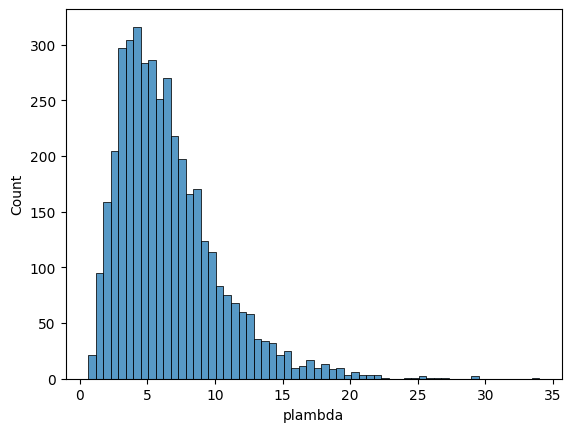

In [268]:
df_final['plambda'] = poisson_model_final.mu
sns.histplot(data=df_final, x="plambda")

In [269]:
aux=((y-poisson_model_final.mu)**2 - poisson_model_final.mu) / poisson_model_final.mu
auxr=sm.OLS(aux, poisson_model_final.mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:       Monthly_Failures   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              5.401
Date:               jue, 24 abr. 2025   Prob (F-statistic):                      0.0202
Time:                        22:42:45   Log-Likelihood:                         -11541.
No. Observations:                4076   AIC:                                  2.308e+04
Df Residuals:                    4075   BIC:                                  2.309e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 8) Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

R: El modelo Binomial Negativa, estimado con el valor de alpha obtenido en la regresión auxiliar, entrega un peor ajuste que el modelo Poisson (menor log-likelihood). Sin embargo, los coeficientes estimados son muy similares, lo que sugiere que las asociaciones identificadas se mantienen.

Variables como P1_Speed, P3_3pm, P4_3pm, P5_9am y Electricity continúan mostrando efectos significativos, manteniéndose robustas en ambas especificaciones. La interpretación de los coeficientes sigue siendo en términos del log del número esperado de fallos, por lo que no cambia respecto al modelo Poisson.

In [270]:
negbin=sm.GLM(y,X2,family=sm.families.NegativeBinomial(alpha= np.exp(0.0197))).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Monthly_Failures   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4064
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11475.
Date:               jue, 24 abr. 2025   Deviance:                       1177.1
Time:                        22:42:45   Pearson chi2:                     959.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2466
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              24.2265      6.776     

## 9) Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?



R: El modelo Poisson (pregunta 6) presentó buen ajuste y permitió identificar relaciones significativas entre varias variables y el número de fallos. Sin embargo, en la pregunta 7 se evidenció una leve sobre-dispersión, lo que motivó el uso del modelo Binomial Negativa en la pregunta 8.

Aunque el Binomial Negativa entregó un peor ajuste (menor log-likelihood), los coeficientes fueron muy similares a los del modelo Poisson, lo que indica estabilidad en los resultados. Dado que la sobre-dispersión es leve, el modelo Poisson es más parsimonioso y, por tanto, más conveniente en este caso.

Las variables P1_Speed, P3_3pm, P4_3pm, P5_9am y Electricity fueron significativas y consistentes en todas las especificaciones, por lo que se consideran robustas.